# BAIT 509: Business Applications of Machine Learning
## Lecture 6 - Model and feature selection
Tomas Beuzen, 22th January 2020

# Lecture outline
- [0. Recap (5 mins)](#0)
- [1. Lecture learning objectives](#1)
- [2. Feature and model selection (5 mins)](#2)
- [3. Feature selection (30 mins)](#3)
- [--- Break --- (10 mins)](#break)
- [4. Model Selection (10 mins)](#4)
- [5. Advanced hyperparameter optimization (20 mins)](#5)
- [6. Class Exercise: feature and model selection (20 mins)](#6)
- [7. Summary questions to ponder](#7)

# Announcements
- Assignment 2 has been released and will be due next **Monday (27th Jan) at 11:59pm**.

# 0. Recap  (5 mins) <a id=0></a>

- Logistic regression
- Naive Bayes

# 1. Lecture learning objectives <a id=1></a>

- Feature selection: how to select features that are important for your models
- Model selection: how to choose the best model for your problem

# 2. Feature and model selection (5 mins) <a id=2></a>

- In supervised learning, we generally seek a model that gives us the lowest generalization error possible. This involves two aspects:
    1. Reducing the irreducible error
    2. Reducing the reducible error

### Reducing irreducible error

- Recall that irreducible error is related to our **data**
- We can't measure everything about a system, and all those things we don't measure contribute to irreducible error
- To reduce irreducible error we can use **feature selection**
- This is about finding and choosing features (data) that gives us as much information about the response as we can get
- Recall our example of predicting a persons height

Predicting height with no other information:
<img src='./img/height.png' width="400"> 

Predicting height knowing that sex=female:
<img src='./img/height_female.png' width="400"> 

Predicting height knowing that sex=female & weight=65kg:
<img src='./img/height_female_65.png' width="400"> 

### Reducing reducible error (bias & variance)

- Recall that reducible error is related to the **model** we are using to relate our features and response
- We want to extract the maximum amount of information that the features hold about the response
- We can do this by **model selection** (choosing a good model) and **hyperparameter optimization (tuning)**
- Recall that reducible error can be decomposed into **bias** and **variance**

<img src='./img/tradeoff.png' width="500">

[Source: dziganto.github.io](https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/) 

# 3. Feature selection (30 mins) <a id=3></a>

- Feature selection is about choosing the best set of features for modelling our response
- You can think of feature selection as a hyperparameter
- **Importantly** feature selection should only be done using the training data! (just like hyperparameter tuning)
- Unfortunately, we can't just throw lots and lots of features at the problem
- Recall that, when tuning a supervised learning method (such as choosing `max_depth` in a decision tree), we can make the training error arbitrarily small (even 0) – but this results in overfitting the training data. The same thing generally applies to the number of features you add - the more features, the more likely you are to overfit.
- Furthermore, more features:
    - add computational cost
    - can disrupt the interpretability of your model,
    - require you to collect more data to actually use your model
- So we generally want to select as few features as possible whilst maximising our model performance ([Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor))
- There are two main kinds of feature selection we'll focus on here:
    1. Univariate feature selection
    2. Wrapper feature selection

## 3.1 Univariate feature selection

### 3.1.1 Categorical data

- Univariate feature selection is the simplest feature selection method
- It works by selecting features based on a univariate statistical metric/test
- For example:
    - Pearson correlation ($r^2$): numeric data
    - Chi-squared ($\chi^2$): categorical data
    - Mutual information: mixed data
    - etc
- The sklearn function [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) is provided for simple univariate feature selection
- It allows us to select the `k` "best" features based on a particular metric
- To demonstrate the method, we will revisit the twitter dataset from last lecture of airline tweets and their sentiments (positive or negative)

In [1]:
# import required packages
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

- Load in the twitter data
- Split into train/test sets

In [2]:
df = pd.read_csv('data/twitter-airline-sentiment.csv')
cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(df['tweet'])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

- I'm going to use Naive Bayes to model my dataset
- There's no hyperparameter tuning here, but I will be making a decision about which features to keep in my model, so I can't use my test data to help me make those decision
- Instead I need to use cross-validation to get an estimate of model performance

In [3]:
model = MultinomialNB()
cv_score = cross_validate(model, X_train, y_train, cv=10)
print(f" Mean error rate = {1 - cv_score['test_score'].mean():.2f}")

 Mean error rate = 0.11


- So I get a pretty low error-rate which is great
- But now I'm going to do some feature selection using `SelectKBest`
- This function works similar to the preprocessing functions we've seen previously
- It has a `.fit()` and `.transform()`
- There are just 2 arguments:
    1. The scoring function (chi2 for classification)
    2. The number of features to keep

In [4]:
selector = SelectKBest(chi2, k=20)
selector.fit(X_train, y_train)

SelectKBest(k=20, score_func=<function chi2 at 0x1a21ab4170>)

- Before we transform our data, let's remind ourselves how many features there were originally
- There were 12,364 features. That's quite a lot!

In [5]:
X_train.shape

(9232, 12364)

- Now let's transform our data and pick only the best 20 features

In [6]:
X_train_new = selector.transform(X_train)

In [7]:
X_train_new.shape

(9232, 20)

- And now use this subset of data to train a new model and do cross-validation again

In [8]:
cv_score = cross_validate(model, X_train, y_train, cv=10)
print(f" Mean error rate = {1 - cv_score['test_score'].mean():.2f}")

 Mean error rate = 0.11


- We have very similar error but by using a much simpler model, only 20 features versus 12,364!!!
- Let's have a look at what those features are to see if they make sense
- The best features are revealed by the `get_support` method of our selector, and their scores are in the `selector.scores_` attribute
- It's a little convoluted to access them, so take your time to understand the code below, which extracts this information and stores it in a nice neat dataframe

In [9]:
best_features = selector.get_support(indices=True)
pd.DataFrame({'feature': np.array(cv.get_feature_names())[best_features], 
              'score': selector.scores_[best_features]}).sort_values(by='score', ascending=False)

,feature,score
16,thank,1044.243959
17,thanks,938.900996
8,great,451.583250
13,love,230.509507
2,awesome,223.013462
11,jetblue,183.832946
0,amazing,182.531895
6,flight,136.000069
3,best,135.021187
18,usairways,131.826308


### 3.1.2 Numeric data

- With regression problems, feature selection is often based on Pearson correlation
- This can be done in sklearn using the `f_regression` functions
- But often people will just do it manually
- I'm going to read in some data describing diabetes patients (the data is available on scikit-learn [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html))
- It contains 10 numeric features of patient physiology and 1 target which is a continuous measure of disease progression

In [10]:
df = pd.read_csv('data/diabetes.csv')
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135


- We can use the built-in Pandas function `.corr()` to calculate Pearson correlation
- We are interested in which features have the highest/lowest correlation with the target

In [11]:
df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


- It's kind of difficult to look at all those numbers
- A more visually-friendly way of doing this is using the plotting package seaborn

(0, 10)

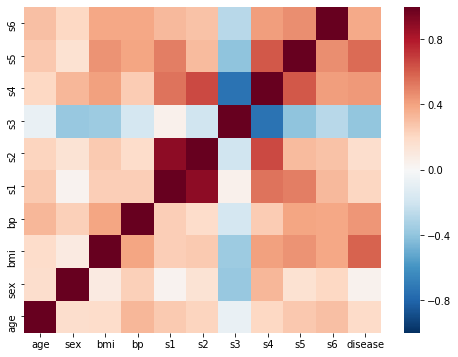

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(df.corr(),
            cmap='RdBu_r', vmin=-1, vmax=1)
plt.ylim(0, 10)

- Things to look for:
    - Features with low correlation with the response (these could be dropped)
    - Features with high correlation with the response (these should be kept and may be important)
    - Features with high correlation with each other (could drop one of these as they are contributing redundant information to the response)
- For the plot above I might:
    - drop the `sex` feature (it has ~0 correlation)
    - drop `s2` (it has high correlation with `s1`)
    - drop `s4` because it is highly correlated with `s1`, `s3`, and `s5`
- Often people will try dropping/keeping different features in the training data set and see how it affects the cross-validation score

## 3.2 Wrapper feature selection

- Wrapper feature selection uses the model itself to evaluate the best subset of features
- It is more computationally expensive than univariate selection, but can give better results because we are using the model itself to help us pick features
- There are two main kinds of wrapper selection:
    1. Exhaustive
    2. Greedy

### 3.2.1 Exhaustive wrapper selection
- This involves testing every single combination of input features
- Guaranteed to give you the global optimum solution for your setup, but computational expensive
- If we have $d$ features, there are approximately $2^d$ subsets of those features to consider/models to build
- For 10 features, that’s 1000 models. For 20 features, that’s over 1,000,000 models
- Here's how the number of models scales with the numer of features:

<img src='./img/combinations.png' width="600"> 

- This functionality is not even built into sklearn at the moment because it's rarely used
- However, there is a package called [mlxtend](http://rasbt.github.io/mlxtend/) which facilitates wrapper selection

### 3.2.2 Greedy wrapper selection

- Instead of fitting all models, we can take a “greedy approach”. This may not result in the optimal model, but the hope is that we get close. One of three methods are typically used:

#### 1. Forward Selection
- The idea here is to start with the null model: no features.
- Then, add one predictor at a time, each time choosing the best one in terms of error reduction.
- Sometimes, a hypothesis test (e.g., F-test) is used to determine whether the addition of the predictor is significant enough.
- Usually we define a threshold that we want the error to decrease by if we add a feature. If we can't exceed this threshold by adding any other feature, we stop.

#### 2. Backward Selection
- The idea here is opposite to **Forward Selection**, we start with the full model: all features.
- Then, we step-wise remove feature based on their effect on error, or based on a hypothesis test.
- Once again, we usually define a threshold to help us stop the algorithm.

#### 3. Stepwise Selection
- This is a combination of forward and backward selection.
- At each step we consider both adding **or** removing features.

- There is a [pull request on GitHub](https://github.com/scikit-learn/scikit-learn/pull/8684) to make this functionality available in sklearn but currently it is not
- They are included in the [mlxtend](http://rasbt.github.io/mlxtend/) package though
- sklearn does have something similar called [Recursive Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination). This is similar to the above, except that instead of choosing features based on model error, it chooses features based on their `feature importance`. As a result, it can only be used with models that have a `feature importance` attribute, e.g., Decision trees, Logistic regression, Naive Bayes, Random Forest, etc.

## 3.3 Other feature selection topics
- **Regularization** = adding a penalty into your optimization function which can reduce/"shrink" the value of unimportant features to 0 (e.g., [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30), [Lasso regression](https://www.youtube.com/watch?v=NGf0voTMlcs)).
- **Dimensionality reduction** = try to represent information in multiple features using fewer contrived features (e.g., [Principal Component Analysis](https://www.youtube.com/watch?v=FgakZw6K1QQ))
- **Feature engineering** = creating new features based on expert knowledge or systematic analysis, [this video](https://www.youtube.com/watch?v=d12ra3b_M-0) does a decent job at explaining it (it's specifically in regards to TensorFlow, another ML library, but the concepts are the same)

# -------- Break (10 mins) -------- <a id="break"></a>

# 4. Model Selection (10 mins) <a id=4></a>

- The question here is, what supervised learning method should you use? Usually we develop multiple different models and then need to choose one. There are a few things you should consider.

### Quantitative choice

- This is about choosing the best model for your problem
- Suppose you’ve gone ahead and fit your best decision tree model, kNN model, logistic regression model, etc. Which do you choose?
- You should have estimated the generalization error for each model (for example, using cross-validation) – so choose the one that gives the lowest error.
- You might find that some models have roughly the same validation error. In this case, you have a few options:
    1. Choose a model based on other criteria (discussed below)
    2. Choose the simplest model (least risk of being overfit)
    3. Use all the model to make predictions of new data (i.e., an ensemble - more to come in a later lecture)

### Qualitative choice
- This could also be called "expert choice"
- It's about adding assumptions to the modelling process based on your expert opinion
- Say that, after exploring the data you think that your response looks linear in your features. If so, it may be reasonable to assume linearity, and fit a linear regression model.

### Interpretability/other contraints
- Sometimes your choice of model is based on considerations other than just error
- For example, you (or your client) might want an interpretable model, like a Decision Tree or Logistic Regression
- You might want a model that predicts in real-time, in which case you need something fast and light-weight

# 5. Advanced hyperparameter optimization (20 mins) <a id="5"></a>

- Hyperparameter optimization is also about reducing the reducible error
- It is to do with how well our model generalizes our data
- We've already done quite a bit of hyperparameter optimization manually, by changing the values of a hyperparameter, doing cross-validation, checking the error, and repeating
- But I now want to introduce you to a more efficient way to tune one or more hyperparameters

## 5.1 sklearn's GridSearchCV

- sklearn provides the function [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to help optimise model hyperparameters
- This method does exactly the process described above, but all wrapped up in one nice convenient function
- It's best illustrated by example
- We will use our good-old cities dataset to demonstrate `GridSearchCV`
- Let's load up the data

In [13]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

- Let's import the `GridSearchCV` library along with a `DecisionTreeClassifier`

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

- The first part of a `GridSearchCV` workflow is to define the hyperparameters you want to test
- You do this in a dictionary which we will call "hyperparams"

In [15]:
hyperparams = {'max_depth': [1, 3, 5, 10]}

- We then treat the `GridSearchCV` object just like any other model in sklearn
- Except that we pass in as arguments, our model and our hyperparameters
- I'm also specifying here `cv=10` to ensure my grid search tests each hyperparameter using 10-fold cross-validation

In [16]:
model = DecisionTreeClassifier()
model_grid = GridSearchCV(model, hyperparams, cv=10)

- We can now fit our model using our training data
- In the fit stage, our grid search is testing every single hyperparameter combination using cross-validation

In [17]:
model_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=None, param_grid={'max_depth': [1, 3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

- We can now access the results of our grid search by exploring its attributes
- The best hyperparameter combination can be found in the `best_params_` attribute
- The best cross-validation score (associated with the best hyperparameter) can be accessed using `best_score_`

In [18]:
print(f"Best hyperparameter: {model_grid.best_params_}")
print(f"Best score: {1 - model_grid.best_score_:.2f}")

Best hyperparameter: {'max_depth': 10}
Best score: 0.11


- If we use our `model_grid` to get a score on our test data, it will automatically use the best hyperparameter combination

In [19]:
print(f"Error on test data: {1- model_grid.score(X_test, y_test):.2f}")

Error on test data: 0.10


- Of course, the real utility here is that we can test multiple hyperparameters at the same time like in the code below

In [20]:
hyperparams = {'max_depth': [1, 3, 5, 10],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [2, 4]}
model = DecisionTreeClassifier()
model_grid = GridSearchCV(model, hyperparams, cv=10, iid=False)
model_grid.fit(X_train, y_train)
print(f"Best hyperparameters: {model_grid.best_params_}")
print(f"Best score: {1 - model_grid.best_score_:.2f}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2}
Best score: 0.10


In [21]:
print(f"Error on test data: {1 - model_grid.score(X_test, y_test):.2f}")

Error on test data: 0.09


## 5.2 sklearn's RandomizedSearchCV

- The problem with GridSearchCV is that, if we have many hyperparameters to tune, it can be computationally expensive
- For example, if we want to tune 3 different hyperparameters, and we are trying 10 different values of each one then we have:
    - 10^3 possible combinations of hyperparameters
    - We usually evaluate each combination using 10-fold cross-validation
    - Which means that we are calling `.fit()/.predict()` 10^4 times
- sklearn provides the function [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) as an alternative to GridSearchCV
- In contrast to GridSearchCV, not all hyperparameter combinations are evaluated
- Instead, only a fixed number of hyperparameter combinations is randomly sampled from the set provided
- This is commonly used in practice for hyperparam optimization

# 6. Class Exercise: feature and model selection (20 mins) <a id="6"></a>
In this class exercise we will practice doing feature and model selection on the airline tweets dataset we've seen a few times already.

Your tasks:

1. Load the data and vectorize it using the `CountVectorizer` function.
2. Split the data into 2 parts: 80% training, 20% testing.
3. Use the `SelectKBest` function with a `chi2` metric to select the best **30** features from the dataset;
4. Now, using `GridSearchCV` for parameter tuning and 5-fold cross-validation, develop four optimum models:
    1. KNNClassifier
    2. DecisionTreeClassifier
    3. LogisitcRegression
    4. MultinomialNaiveBayes
5. Select your best model and test it on the your test data.

In [22]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.ensemble import VotingClassifier

# Question 1 and 2
df = pd.read_csv('data/twitter-airline-sentiment.csv')
cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(df['tweet'])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Question 3
selector = SelectKBest(chi2, k=30)
X_train_30 = selector.fit_transform(X_train, y_train)
X_test_30 = selector.transform(X_test)

# Question 4
# I will first define a dictionary of the different models I want to test
models = {
    'KNN': GridSearchCV(KNeighborsClassifier(),
                        param_grid = {'n_neighbors': np.arange(1, 20, 2)},
                        cv=5),
    'DT': GridSearchCV(DecisionTreeClassifier(),
                       param_grid = {'max_depth': np.arange(1, 20, 2)},
                       cv=5),
    'LR': GridSearchCV(LogisticRegression(solver='lbfgs'),
                       param_grid = {'C': [0.01, 0.1, 1.0]},
                       cv=5),
    'NB': GridSearchCV(MultinomialNB(),
                       param_grid = {'alpha': [0.01, 0.1, 1, 10]},
                       cv=5)}
# I will now loop over each model in my dictionary and find the score
print("*** Hyperparameter tuning ***")
for name, model in models.items():
    model.fit(X_train_30, y_train)
    print(f"{name} best hyperparams = {model.best_params_}.")
    print(f"{name} error: {1 - model.best_score_:.2f}")
    
# Question 5
# Naive Bayes is the best model (although they are all similar)
print("")
print("*** Best model ***")
best_model = MultinomialNB(alpha=0.01).fit(X_train_30, y_train)
print(f"Error on test data: {1 - best_model.score(X_test_30, y_test):.2f}")

# Bonus material
# All our classifiers did well so why not use all of them to make predictions?
# We can do this with the VotingClassifier (which we'll learn about in a later lecture)
# Turns out that this ensemble approach doesn't really do much better than our single Naive Bayes model
print("")
print("*** Voting classifier ***")
voter = VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=7)),
                                     ('DT', DecisionTreeClassifier(max_depth=15)),
                                     ('LR', LogisticRegression(solver='lbfgs', C=1)),
                                     ('NB', MultinomialNB(alpha=0.01))],
                         voting='soft')
voter.fit(X_train_30, y_train)
print(f"Error on test data: {1 - voter.score(X_test_30, y_test):.2f}")

*** Hyperparameter tuning ***
KNN best hyperparams = {'n_neighbors': 7}.
KNN error: 0.13
DT best hyperparams = {'max_depth': 15}.
DT error: 0.13
LR best hyperparams = {'C': 1.0}.
LR error: 0.12
NB best hyperparams = {'alpha': 0.01}.
NB error: 0.12

*** Best model ***
Error on test data: 0.12

*** Voting classifier ***
Error on test data: 0.11


# 7. Summary questions to ponder <a id=7></a>
1. How can we start forming good business questions that can be addressed with Machine Learning
2. Is there any easier way to group our models, preprocessing, feature selection, etc into one workflow?
